step 1 :

goal = My goal is to predict which users are most likely to churn (stop returning or purchasing) and provide actionable insights into why they might churn, focusing on factors like user behavior, preferences, and session activity.




The research paper highlights how important it is to identify users who might leave, which fits with my goal of predicting and understanding why users churn. By looking at event data like views, carts, and purchases, as well as session activity, I can spot users who are disengaging or not buying. Personalization is key, so I can create strategies tailored to users’ preferences—like offering deals to those who frequently look at a certain brand but haven't bought anything. By studying behaviors like how long users stay on the site, how often they interact, and if they abandon their cart, I can get a clearer picture of why they're churning. This helps me come up with practical solutions, such as targeted marketing. To make the predictions even more accurate, I’ll use advanced machine learning techniques to improve how I predict and prevent churn.

In [2]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ydata_profiling import ProfileReport

In [3]:
data = pd.read_csv("/kaggle/input/eventsdata/events.csv")

In [ ]:
# Create a pandas-profiling report
profile = ProfileReport(data, title="Event Count per User", explorative=True)

# Save the report to an HTML file
profile.to_file("event_count_report.html")

I conducted a Pandas Profiling analysis to generate an in-depth exploratory data analysis report, which provided valuable insights into the dataset’s structure, distributions, correlations, and potential data quality issues.








-- event_time,event_type,product_id,category_id, has no miising values

-- category_code has 5361(30.2%) Missing values,brand 4724(	26.7%) Missing values

-- price,user_id have 1 and user_session 5 Missing values

In [4]:
#2.	Data Inspection & Preprocessing

# Handle missing values

# Step 1: Replace missing 'category_code' with the most frequent category for the same 'brand'
category_mode_by_brand = data.groupby('brand')['category_code'].apply(lambda x: x.mode()[0] if not x.isna().all() else np.nan)
data['category_code'] = data.apply(
    lambda row: category_mode_by_brand[row['brand']] if pd.isna(row['category_code']) and row['brand'] in category_mode_by_brand else row['category_code'],
    axis=1
)

# Step 2: Replace missing 'brand' with the most frequent brand for the same 'category_code'
brand_mode_by_category = data.groupby('category_code')['brand'].apply(lambda x: x.mode()[0] if not x.isna().all() else np.nan)
data['brand'] = data.apply(
    lambda row: brand_mode_by_category[row['category_code']] if pd.isna(row['brand']) and row['category_code'] in brand_mode_by_category else row['brand'],
    axis=1
)

# Step 3: Drop rows where both 'category_code' and 'brand' are missing
data = data.dropna(subset=['category_code', 'brand'], how='all')

# Display the cleaned dataset
print("Cleaned Dataset:")
print(data)


Cleaned Dataset:
                     event_time event_type  product_id          category_id  \
0       2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1       2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
3       2020-09-24 11:57:33 UTC       view      635807  2144415923107266682   
4       2020-09-24 11:57:36 UTC       view     3658723  2144415921169498184   
5       2020-09-24 11:57:59 UTC       view      664325  2144415951611757447   
...                         ...        ...         ...                  ...   
885123  2021-02-28 23:54:18 UTC       view     3829355  2144415922528452715   
885125  2021-02-28 23:58:05 UTC       view     1715907  2144415927049912542   
885126  2021-02-28 23:58:09 UTC       view     4170534  2144415939364389423   
885127  2021-02-28 23:58:14 UTC       view      888273  2144415921932861531   
885128  2021-02-28 23:59:09 UTC       view      743182  2144415935631458761   

                        category_c

In [5]:
brands_with_missing_category = data[data['brand'].isna()]['category_code'].unique()

# Replace missing 'category_code' with 'Unknown' if the 'brand' has no category
data['brand'] = data.apply(
    lambda row: 'Unknown' if pd.isna(row['brand']) and row['category_code'] in brands_with_missing_category else row['brand'],
    axis=1
)

brands_with_missing_category = data[data['category_code'].isna()]['brand'].unique()

# Replace missing 'brand' with 'Unknown' if the 'category_code' has no category
data['category_code'] = data.apply(
    lambda row: 'Unknown' if pd.isna(row['category_code']) and row['brand'] in brands_with_missing_category else row['category_code'],
    axis=1
)

In [6]:

# Drop rows with missing 'price' or 'user_id' since these are crucial
data = data.dropna(subset=['price', 'user_id'])

# Replace missing 'user_session' with 'Unknown'
data['user_session'] = data['user_session'].fillna("Unknown")


In [7]:
print("\nAfter Cleaning:")
print(data.info())  # Verify nulls are removed
print(data.describe(include='all'))


After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 805326 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     805326 non-null  object 
 1   event_type     805326 non-null  object 
 2   product_id     805326 non-null  int64  
 3   category_id    805326 non-null  int64  
 4   category_code  805326 non-null  object 
 5   brand          805326 non-null  object 
 6   price          805326 non-null  float64
 7   user_id        805326 non-null  int64  
 8   user_session   805326 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 61.4+ MB
None
                     event_time event_type    product_id   category_id  \
count                    805326     805326  8.053260e+05  8.053260e+05   
unique                   771606          3           NaN           NaN   
top     2021-02-04 21:48:32 UTC       view           NaN           NaN   
freq               

In [8]:
# exact duplicates across all columns
exact_duplicates = data[data.duplicated(keep=False)] # Keeps all instances of duplicates
print(exact_duplicates)


                     event_time event_type  product_id          category_id  \
511     2020-09-24 13:51:07 UTC       view      387956  2144415922427789416   
512     2020-09-24 13:51:07 UTC       view      387956  2144415922427789416   
974     2020-09-24 15:48:55 UTC       view      874667  2144415922738167921   
975     2020-09-24 15:48:55 UTC       view      874667  2144415922738167921   
4827    2020-09-25 13:15:09 UTC       view      453469  2144415924222951574   
...                         ...        ...         ...                  ...   
878751  2021-02-27 17:56:05 UTC       view     1571204  2144415924491387038   
879544  2021-02-27 20:54:20 UTC       view     1027953  2144415923837075596   
879545  2021-02-27 20:54:20 UTC       view     1027953  2144415923837075596   
882715  2021-02-28 14:18:02 UTC       view     4078916  2144415922427789416   
882716  2021-02-28 14:18:02 UTC       view     4078916  2144415922427789416   

                           category_code       bran

In [9]:
# Drop exact duplicates
data_cleaned = data.drop_duplicates()
print(data_cleaned)


                     event_time event_type  product_id          category_id  \
0       2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1       2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
3       2020-09-24 11:57:33 UTC       view      635807  2144415923107266682   
4       2020-09-24 11:57:36 UTC       view     3658723  2144415921169498184   
5       2020-09-24 11:57:59 UTC       view      664325  2144415951611757447   
...                         ...        ...         ...                  ...   
885123  2021-02-28 23:54:18 UTC       view     3829355  2144415922528452715   
885125  2021-02-28 23:58:05 UTC       view     1715907  2144415927049912542   
885126  2021-02-28 23:58:09 UTC       view     4170534  2144415939364389423   
885127  2021-02-28 23:58:14 UTC       view      888273  2144415921932861531   
885128  2021-02-28 23:59:09 UTC       view      743182  2144415935631458761   

                        category_code        brand 

In [10]:
#Parse event_time to datetime format

data['event_time'] = pd.to_datetime(data['event_time'])

print(data.dtypes)

event_time       datetime64[ns, UTC]
event_type                    object
product_id                     int64
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
dtype: object


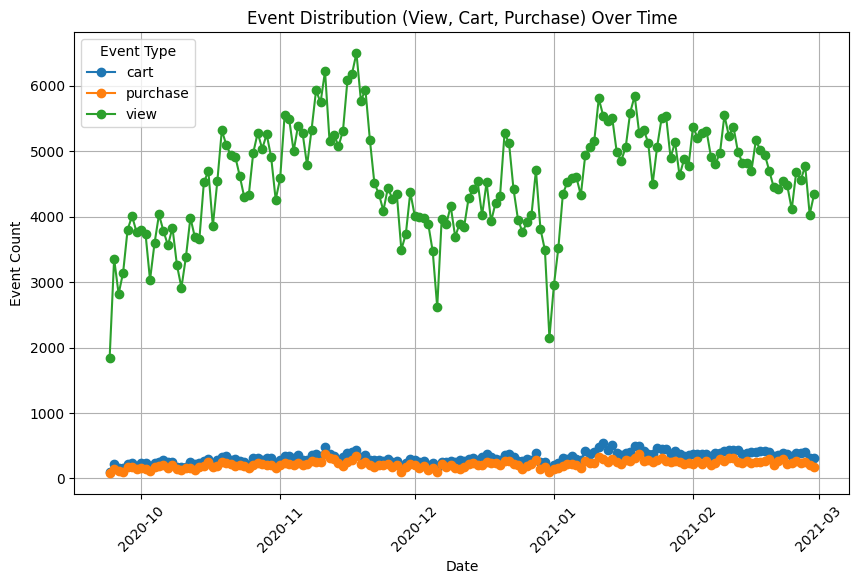

In [21]:
#EDA

# Group by event type and day
data['date'] = data['event_time'].dt.date  # Extract the date from event_time
event_distribution = data.groupby(['date', 'event_type']).size().unstack(fill_value=0)

event_distribution.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Event Distribution (View, Cart, Purchase) Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.grid(True)
plt.show()

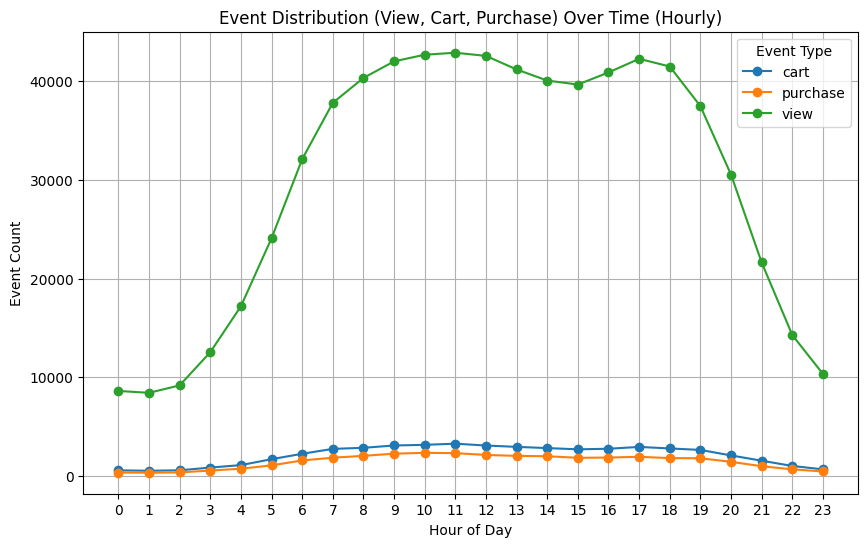

In [12]:
# Group by event type and hour
data['hour'] = data['event_time'].dt.hour  # Extract the hour from event_time
event_distribution_hourly = data.groupby(['hour', 'event_type']).size().unstack(fill_value=0)


event_distribution_hourly.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Event Distribution (View, Cart, Purchase) Over Time (Hourly)')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count')
plt.xticks(range(0, 24))  # Show all hours of the day
plt.legend(title='Event Type')
plt.grid(True)
plt.show()

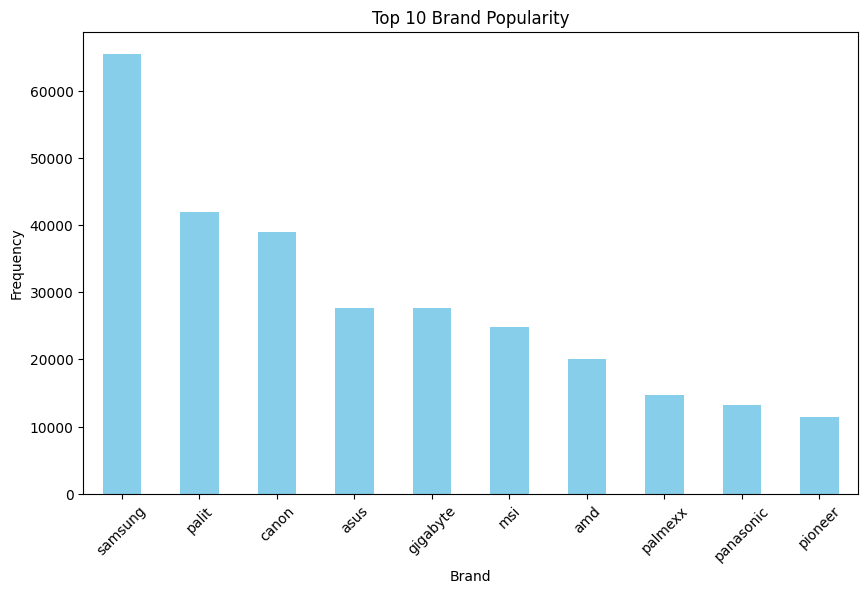

In [22]:
# Plot the brand popularity
# Count the occurrences of each brand
brand_popularity = data['brand'].value_counts()

plt.figure(figsize=(10, 6))
brand_popularity.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Brand Popularity')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

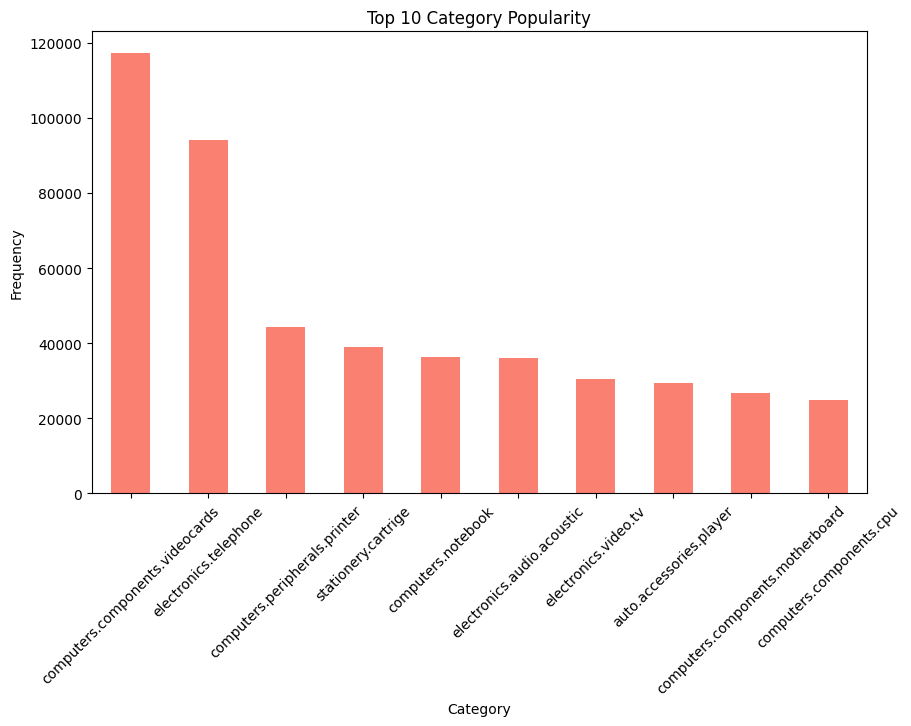

In [23]:
# Count the occurrences of each category_code
category_popularity = data['category_code'].value_counts()

# Plot the category popularity
plt.figure(figsize=(10, 6))
category_popularity.head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Category Popularity')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()



Segmentation:

High View, Low Cart, Lowest Purchase: Many people view products, but fewer add them to the cart, and even fewer actually buy them.

View Events:

The View event count shows the highest overall frequency, indicating that a large number of users are viewing products throughout the day. There is a significant peak in View events around 10 AM, suggesting a morning surge in user activity. The View event count remains high until around 6 PM, after which it starts to decline.

Cart Events:

The Cart event count is lower than the View event count, which is expected as not every product viewed is added to the cart. The Cart event count generally follows a similar trend to the View event count, with a peak around 10 AM and a gradual decline.

Purchase Events:

The Purchase event count is the lowest among the three event types, indicating that only a fraction of products added to the cart are actually purchased. The Purchase event count also exhibits a peak around 10 AM, but it is less pronounced compared to the View and Cart event counts

Brand Loyalty:

Samsung's high popularity could indicate strong brand loyalty among consumers.

In [24]:
#2.	Churn Definition & Reasoning
data['event_time'] = pd.to_datetime(data['event_time'], utc=True)
today = data['event_time'].max()  
last_interaction = data.groupby('user_id')['event_time'].max()  # Latest event time per user
recency = (today - last_interaction).dt.days  # Days since last interaction
recency_values = recency.unique()

Mean Recency: 78.5
Median Recency: 78.5
75th Percentile: 117.75


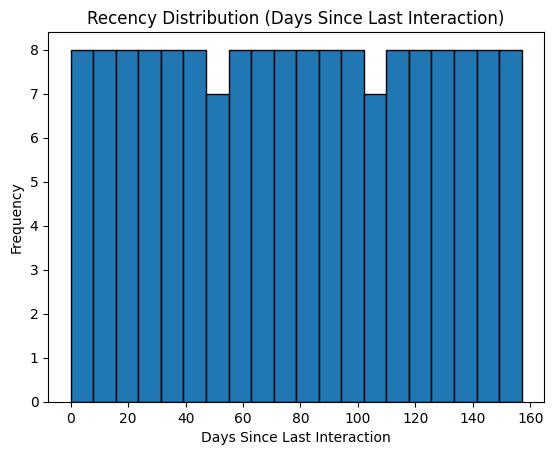

In [25]:
mean_recency = np.mean(recency_values)
median_recency = np.median(recency_values)
percentile_75 = np.percentile(recency_values, 75)

print(f"Mean Recency: {mean_recency}")
print(f"Median Recency: {median_recency}")
print(f"75th Percentile: {percentile_75}")

plt.hist(recency_values, bins=20, edgecolor='black')
plt.title('Recency Distribution (Days Since Last Interaction)')
plt.xlabel('Days Since Last Interaction')
plt.ylabel('Frequency')
plt.show()

In [32]:
churn_threshold = 117  # Churn threshold in days

# Classify users as 'Churned' or 'Active' based on recency
churn_status = recency.apply(lambda x: 'Churned' if x > churn_threshold else 'Active')

# Combine churn status with user information
user_churn = pd.DataFrame({
    'user_id': recency.index,
    'recency': recency.values,
    'churn_status': churn_status.values
})

# Display the churn status for each user
print(user_churn.sample(20))

                    user_id  recency churn_status
345473  1515915625606948557       10       Active
161518  1515915625543366411       96       Active
83618   1515915625531533645      123      Churned
327984  1515915625603695473       18       Active
43356   1515915625525644781      138      Churned
145933  1515915625541009851      101       Active
169217  1515915625545756115       92       Active
14847   1515915625520744800      152      Churned
305797  1515915625599304572       27       Active
147354  1515915625541232826      101       Active
316008  1515915625600857385       23       Active
55548   1515915625527528505       72       Active
217632  1515915625566544408       68       Active
203319  1515915625563523803       75       Active
67805   1515915625529258534      129      Churned
220795  1515915625567566556       67       Active
23466   1515915625522131705       11       Active
351024  1515915625608035062        7       Active
120697  1515915625537808656      110       Active


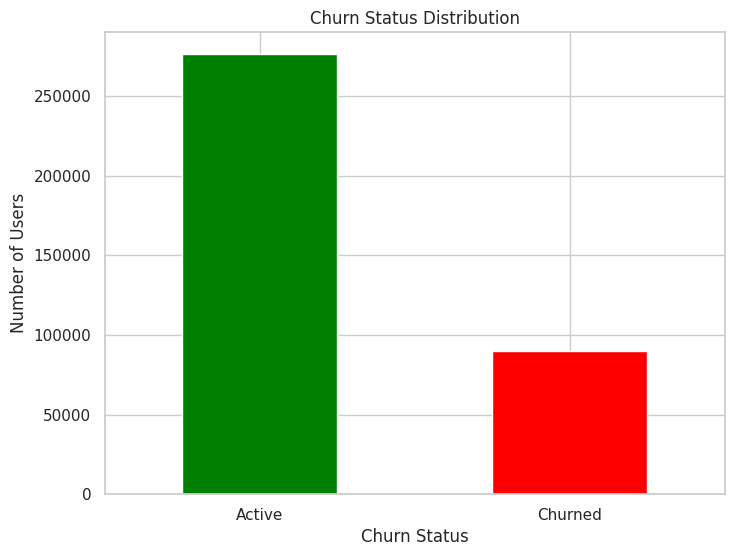

In [33]:
plt.figure(figsize=(8, 6))
user_churn['churn_status'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Churn Status Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

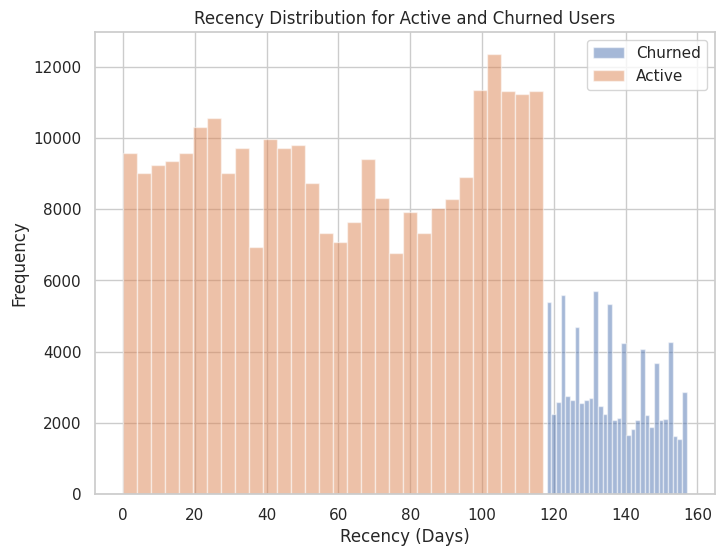

In [34]:
plt.figure(figsize=(8, 6))
for status in user_churn['churn_status'].unique():
    plt.hist(user_churn[user_churn['churn_status'] == status]['recency'], bins=30, alpha=0.5, label=status)

plt.title('Recency Distribution for Active and Churned Users')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [35]:
data = data.merge(user_churn[['user_id', 'recency', 'churn_status']], on='user_id', how='left')

# Checking if the merge worked correctly by inspecting the data

print(data.head())

                 event_time event_type  product_id          category_id  \
0 2020-09-24 11:57:06+00:00       view     1996170  2144415922528452715   
1 2020-09-24 11:57:26+00:00       view      139905  2144415926932472027   
2 2020-09-24 11:57:33+00:00       view      635807  2144415923107266682   
3 2020-09-24 11:57:36+00:00       view     3658723  2144415921169498184   
4 2020-09-24 11:57:59+00:00       view      664325  2144415951611757447   

                   category_code        brand   price              user_id  \
0          electronics.telephone      samsung   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2  computers.peripherals.printer       pantum  113.81  1515915625519014356   
3     electronics.audio.acoustic  cameronsino   15.87  1515915625510743344   
4         construction.tools.saw       carver   52.33  1515915625519388062   

  user_session        date  hour  recency_x churn_status_x  recency_y  \
0   LJu

In [36]:
churned_customers = user_churn[user_churn['churn_status'] == "Churned"]
churned_customers

,user_id,recency,churn_status
0,1515915625353226922,122,Churned
1,1515915625353230067,145,Churned
3,1515915625353230922,149,Churned
6,1515915625353238403,135,Churned
7,1515915625353262977,156,Churned
...,...,...,...
98599,1515915625533935060,118,Churned
98600,1515915625533935160,118,Churned
98601,1515915625533935175,118,Churned
98602,1515915625533935310,118,Churned


In [37]:
recency_data = data.groupby('user_id')['event_time'].max().reset_index()
recency_data['recency'] = (data['event_time'].max() - recency_data['event_time']).dt.days

frequency_data = data.groupby('user_id')['user_session'].nunique().reset_index()
frequency_data.rename(columns={'user_session': 'frequency'}, inplace=True)

monetary_data = data[data['event_type'] == 'purchase'].groupby('user_id')['price'].sum().reset_index()
monetary_data.rename(columns={'price': 'monetary_value'}, inplace=True)

In [39]:
rfm_data = recency_data.merge(frequency_data, on='user_id', how='left')
rfm_data = rfm_data.merge(monetary_data, on='user_id', how='left')
rfm_data.fillna({'monetary_value': 0}, inplace=True)

rfm_data

,user_id,event_time,recency,frequency,monetary_value
0,1515915625353226922,2020-10-29 11:28:35+00:00,122,1,0.0
1,1515915625353230067,2020-10-06 06:30:32+00:00,145,1,0.0
2,1515915625353230683,2020-12-12 10:33:09+00:00,78,4,0.0
3,1515915625353230922,2020-10-02 08:23:40+00:00,149,1,0.0
4,1515915625353234047,2021-02-18 09:11:44+00:00,10,1,0.0
...,...,...,...,...,...
366259,1515915625611023581,2021-02-28 23:53:13+00:00,0,1,0.0
366260,1515915625611023671,2021-02-28 23:54:18+00:00,0,1,0.0
366261,1515915625611024014,2021-02-28 23:58:05+00:00,0,1,0.0
366262,1515915625611024020,2021-02-28 23:58:09+00:00,0,1,0.0


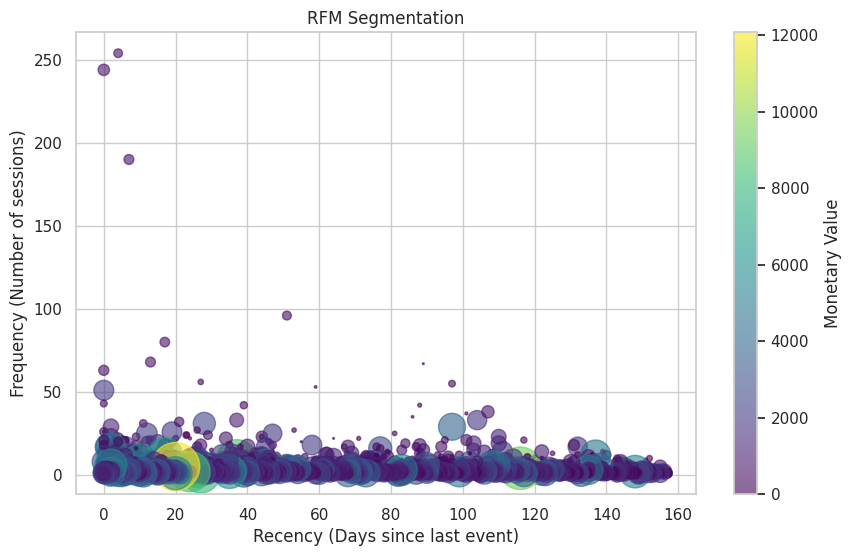

In [40]:


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot: Recency vs Frequency, with size indicating monetary value
plt.scatter(
    rfm_data['recency'], 
    rfm_data['frequency'], 
    s=rfm_data['monetary_value'] / 10,  # Scale size for better visualization
    alpha=0.6, 
    c=rfm_data['monetary_value'],  # Color by monetary value
    cmap='viridis'
)

# Add labels and title
plt.title('RFM Segmentation')
plt.xlabel('Recency (Days since last event)')
plt.ylabel('Frequency (Number of sessions)')
plt.colorbar(label='Monetary Value')

# Show plot
plt.show()


The plot reveals a concentration of sessions with low recency and frequency, suggesting that many customers have not engaged recently or frequently. However, there are a few outliers with higher frequency and monetary value, indicating a small group of highly valuable and engaged customers

In [42]:
# Calculating the counts before applying the aggregation functions
views = data[data['event_type'] == 'view'].groupby('user_id').size()
carts = data[data['event_type'] == 'cart'].groupby('user_id').size()
purchases = data[data['event_type'] == 'purchase'].groupby('user_id').size()

# Merge the counts back into a single dataframe
behavior_data = pd.DataFrame({
    'view_count': views,
    'cart_count': carts,
    'purchase_count': purchases
}).fillna(0)

# Calculate the ratios
behavior_data['view_to_cart_ratio'] = behavior_data['cart_count'] / behavior_data['view_count'].replace(0, 1)
behavior_data['cart_to_purchase_ratio'] = behavior_data['purchase_count'] / behavior_data['cart_count'].replace(0, 1)

# Calculate the average time between events
# First, ensure event_time is sorted
data = data.sort_values(['user_id', 'event_time'])

# Calculate the time difference between events per user
data['time_diff'] = data.groupby('user_id')['event_time'].diff().dt.total_seconds()

# Calculate the average time difference per user
avg_time_diff = data.groupby('user_id')['time_diff'].mean()

# Merge the time difference into behavior_data
behavior_data['avg_time_between_events'] = avg_time_diff

# Reset index for final output
behavior_data = behavior_data.reset_index()


<Figure size 1200x800 with 0 Axes>

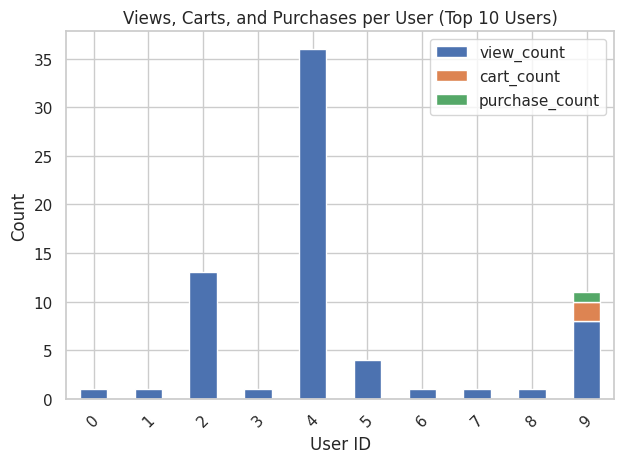

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


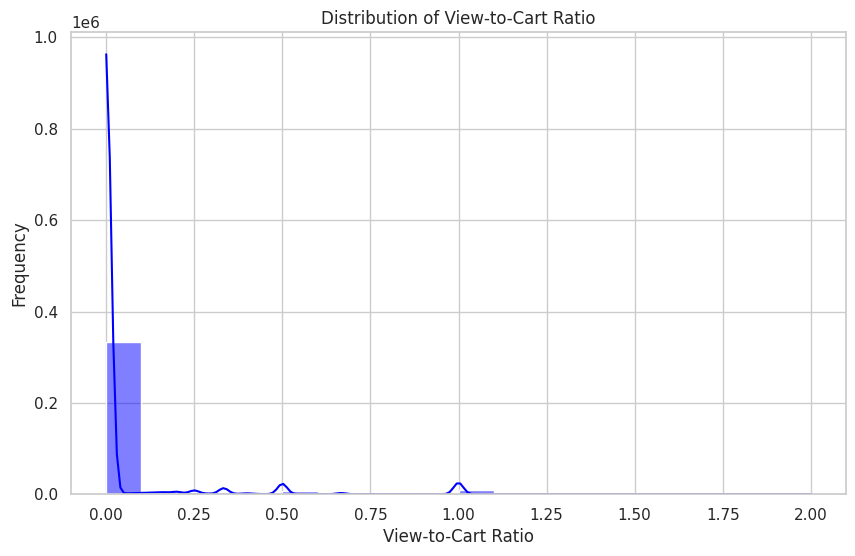

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


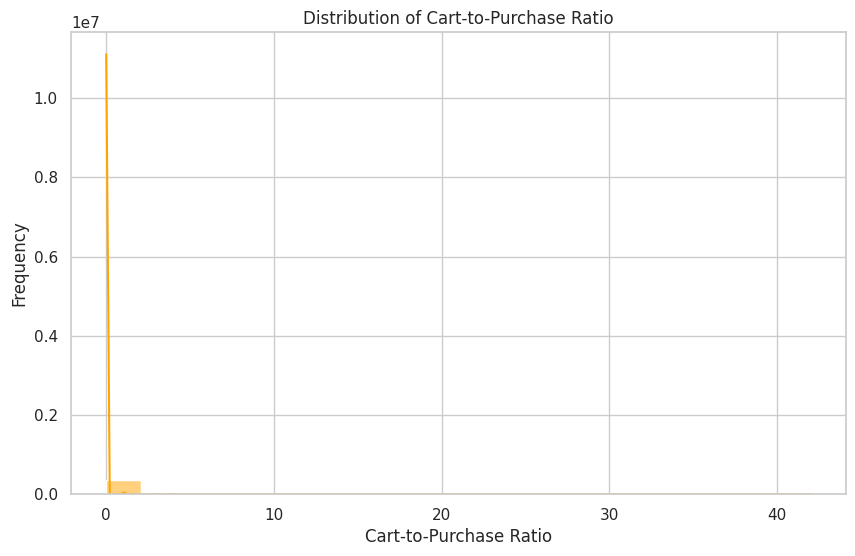

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


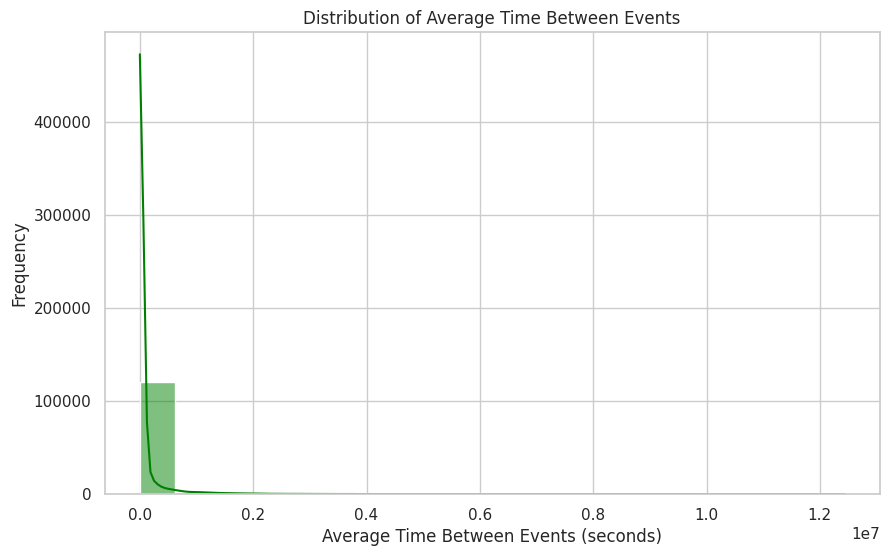

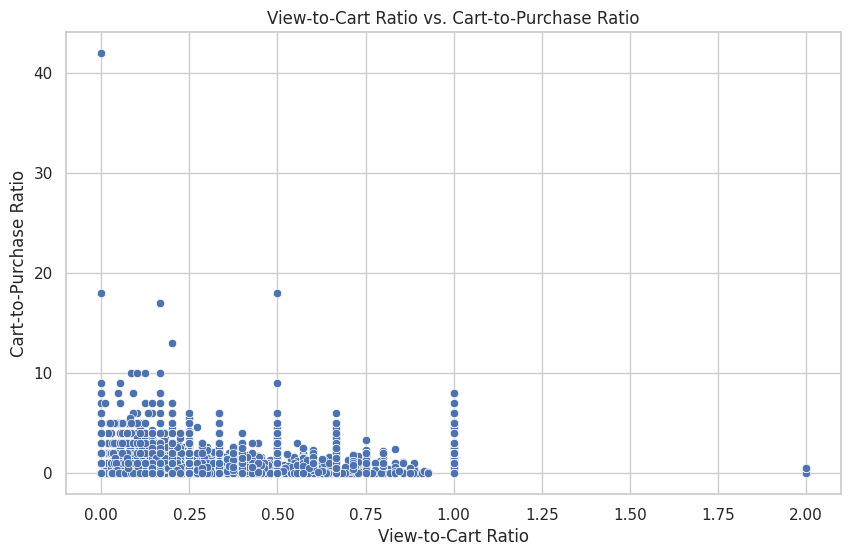

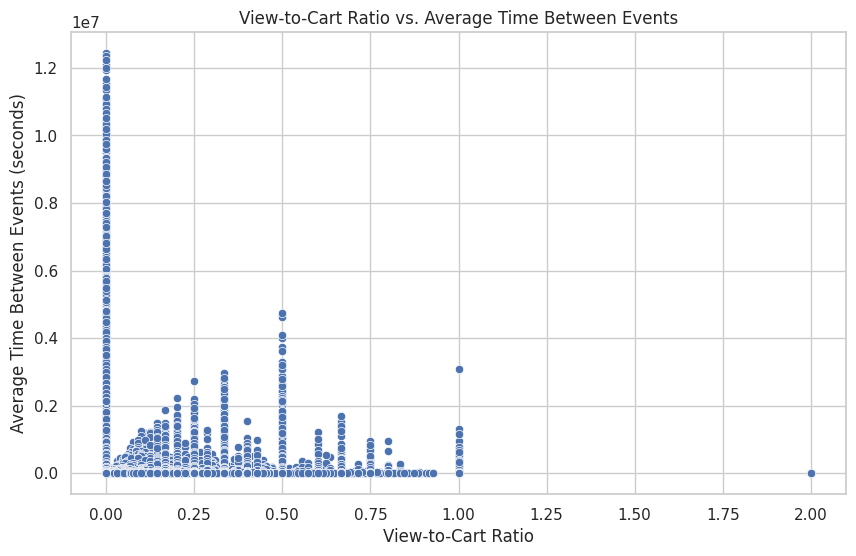

In [43]:

plt.figure(figsize=(12, 8))

# 1. Bar Plot: Show the count of views, carts, and purchases for each user
behavior_data[['view_count', 'cart_count', 'purchase_count']].head(10).plot(kind='bar', stacked=True)
plt.title('Views, Carts, and Purchases per User (Top 10 Users)')
plt.xlabel('User ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Histogram: View-to-Cart Ratio
plt.figure(figsize=(10, 6))
sns.histplot(behavior_data['view_to_cart_ratio'], kde=True, color='blue', bins=20)
plt.title('Distribution of View-to-Cart Ratio')
plt.xlabel('View-to-Cart Ratio')
plt.ylabel('Frequency')
plt.show()

# 3. Histogram: Cart-to-Purchase Ratio
plt.figure(figsize=(10, 6))
sns.histplot(behavior_data['cart_to_purchase_ratio'], kde=True, color='orange', bins=20)
plt.title('Distribution of Cart-to-Purchase Ratio')
plt.xlabel('Cart-to-Purchase Ratio')
plt.ylabel('Frequency')
plt.show()

# 4. Histogram: Average Time Between Events
plt.figure(figsize=(10, 6))
sns.histplot(behavior_data['avg_time_between_events'], kde=True, color='green', bins=20)
plt.title('Distribution of Average Time Between Events')
plt.xlabel('Average Time Between Events (seconds)')
plt.ylabel('Frequency')
plt.show()

# 5. Scatter Plot: View-to-Cart Ratio vs. Cart-to-Purchase Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(x=behavior_data['view_to_cart_ratio'], y=behavior_data['cart_to_purchase_ratio'])
plt.title('View-to-Cart Ratio vs. Cart-to-Purchase Ratio')
plt.xlabel('View-to-Cart Ratio')
plt.ylabel('Cart-to-Purchase Ratio')
plt.show()

# 6. Scatter Plot: View-to-Cart Ratio vs. Average Time Between Events
plt.figure(figsize=(10, 6))
sns.scatterplot(x=behavior_data['view_to_cart_ratio'], y=behavior_data['avg_time_between_events'])
plt.title('View-to-Cart Ratio vs. Average Time Between Events')
plt.xlabel('View-to-Cart Ratio')
plt.ylabel('Average Time Between Events (seconds)')
plt.show()


The bar chart titled "Views, Carts, and Purchases per User (Top 10 Users)" provides some interesting insights:

User ID 4 has the highest number of views, with over 35 views.

User ID 2 follows with around 12 views.

User ID 9 stands out with a significant number of views, carts, and purchases, having the highest combined total of cart_count and purchase_count.

Other users have relatively low counts in all three categories.

The histogram titled "Distribution of View-to-Cart Ratio" shows that most users have a very low view-to-cart ratio, with a high frequency near the 0.00 mark. This suggests that many users view products but do not add them to their carts. The frequency decreases sharply as the view-to-cart ratio increases, indicating that fewer users have higher view-to-cart ratios.

The histogram titled "Distribution of Cart-to-Purchase Ratio" shows that the majority of users have a very low cart-to-purchase ratio, with a high frequency near the 0.00 mark. This suggests that many users add items to their carts but do not complete the purchase. The frequency decreases significantly as the cart-to-purchase ratio increases, indicating that fewer users have higher ratios.

The scatter plot titled "View-to-Cart Ratio vs. Cart-to-Purchase Ratio :

Most data points are clustered towards the lower end of both axes, suggesting that many users have low ratios in both categories. However, there are a few outliers with higher Cart-to-Purchase Ratios, indicating that some users are more likely to complete purchases after adding items to their carts.

This graph can help identify areas for improvement in the user experience or marketing strategies to encourage more users to add items to their carts and complete purchases.

In [45]:
# Step 1: Calculate session-level metrics (session_duration, session_event_count)
session_data = data.groupby('user_session').agg(
    session_duration=('event_time', lambda x: (x.max() - x.min()).total_seconds()),
    session_event_count=('event_type', 'count'),
    user_id=('user_id', 'first')  # Add user_id to avoid repeated lookups
).reset_index()

# Step 2: Aggregate session_data by user_id
user_session_data = session_data.groupby('user_id').agg(
    total_sessions=('user_session', 'nunique'),
    avg_session_duration=('session_duration', 'mean'),
    bounce_rate=('session_event_count', lambda x: (x == 1).sum() / len(x))
).reset_index()

# Output the final user-level session summary
user_session_data


,user_id,total_sessions,avg_session_duration,bounce_rate
0,1515915625353226922,1,0.0,1.0
1,1515915625353230067,1,0.0,1.0
2,1515915625353230683,4,624.5,0.5
3,1515915625353230922,1,0.0,1.0
4,1515915625353234047,1,12244190.0,0.0
...,...,...,...,...
366044,1515915625611023581,1,0.0,1.0
366045,1515915625611023671,1,0.0,1.0
366046,1515915625611024014,1,0.0,1.0
366047,1515915625611024020,1,0.0,1.0


<Figure size 1200x800 with 0 Axes>

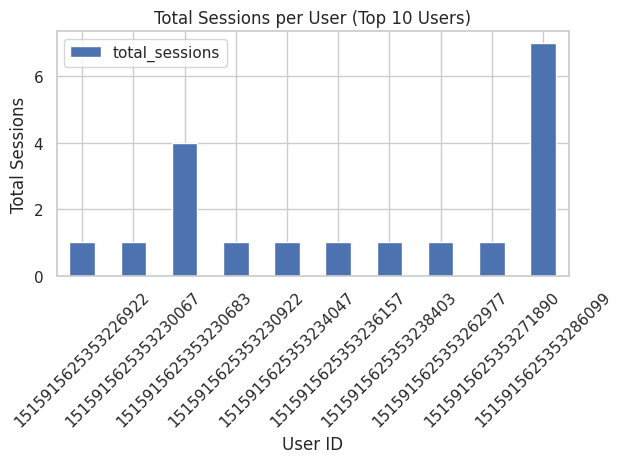

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


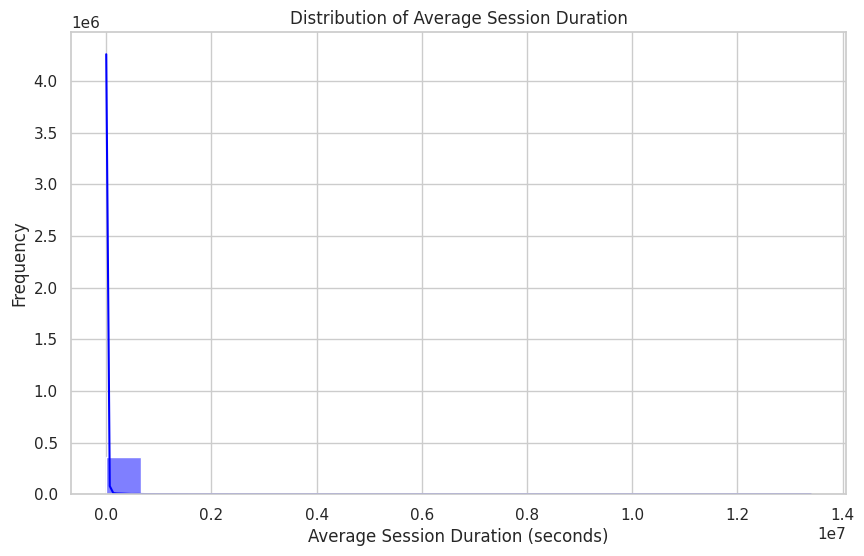

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


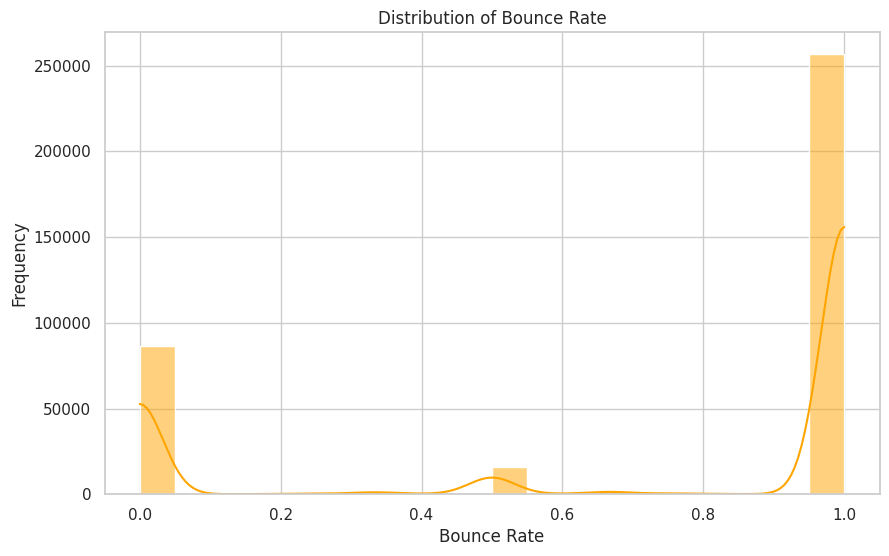

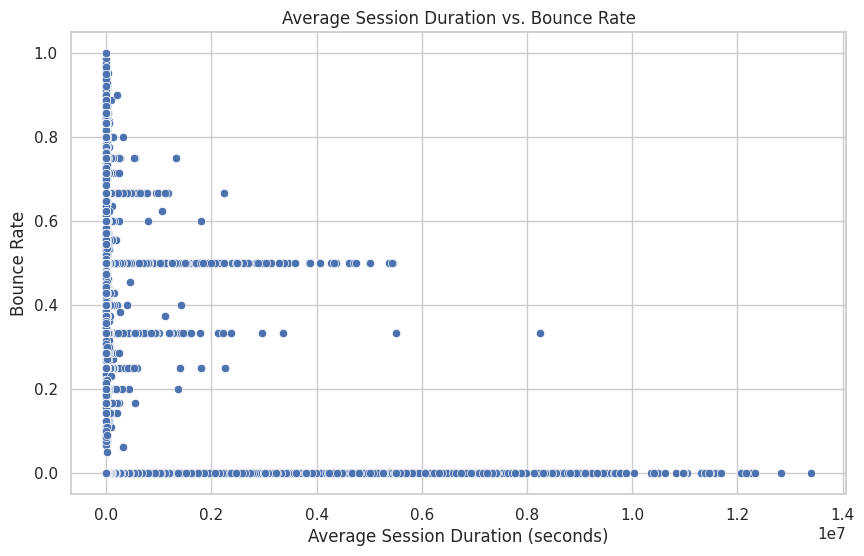

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size
plt.figure(figsize=(12, 8))

# 1. Bar Plot: Total Sessions per User (Top 10 Users)
user_session_data[['user_id', 'total_sessions']].head(10).plot(kind='bar', x='user_id', stacked=True)
plt.title('Total Sessions per User (Top 10 Users)')
plt.xlabel('User ID')
plt.ylabel('Total Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Histogram: Distribution of Average Session Duration
plt.figure(figsize=(10, 6))
sns.histplot(user_session_data['avg_session_duration'], kde=True, color='blue', bins=20)
plt.title('Distribution of Average Session Duration')
plt.xlabel('Average Session Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# 3. Histogram: Distribution of Bounce Rate
plt.figure(figsize=(10, 6))
sns.histplot(user_session_data['bounce_rate'], kde=True, color='orange', bins=20)
plt.title('Distribution of Bounce Rate')
plt.xlabel('Bounce Rate')
plt.ylabel('Frequency')
plt.show()

# 4. Scatter Plot: Average Session Duration vs. Bounce Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x=user_session_data['avg_session_duration'], y=user_session_data['bounce_rate'])
plt.title('Average Session Duration vs. Bounce Rate')
plt.xlabel('Average Session Duration (seconds)')
plt.ylabel('Bounce Rate')
plt.show()


The histogram titled "Distribution of Average Session Duration" shows that most sessions are of short duration.
This suggests that the majority of users have short sessions, which could indicate that they are either finding what they need quickly or not engaging deeply with the content. This insight can help identify areas for improvement in user engagement strategies.

The histogram titled "Distribution of Bounce Rate" shows This suggests that a significant number of sessions either result in immediate bounces or users staying for a longer duration.

The bounce rate varies across the entire range, but there is no clear pattern or correlation visible between the average session duration and the bounce rate. This suggests that while many users have short sessions, their bounce rates can vary widely.

In [47]:
# Step 1: Extract temporal features from event_time
data['event_hour'] = data['event_time'].dt.hour
data['event_day'] = data['event_time'].dt.dayofweek

# Step 2: Aggregate temporal features by user_id
temporal_features = data.groupby('user_id').agg(
    avg_activity_hour=('event_hour', 'mean'),
    most_active_day=('event_day', lambda x: x.mode().iloc[0] if not x.mode().empty else None)
).reset_index()

# Output the result
temporal_features


,user_id,avg_activity_hour,most_active_day
0,1515915625353226922,11.000000,3
1,1515915625353230067,6.000000,1
2,1515915625353230683,9.307692,0
3,1515915625353230922,8.000000,4
4,1515915625353234047,8.694444,3
...,...,...,...
366259,1515915625611023581,23.000000,6
366260,1515915625611023671,23.000000,6
366261,1515915625611024014,23.000000,6
366262,1515915625611024020,23.000000,6


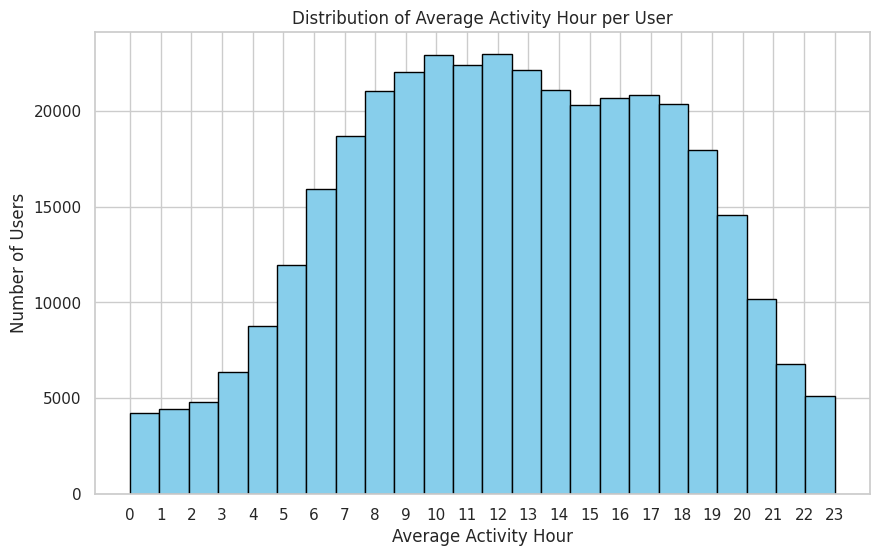

In [48]:

plt.figure(figsize=(10, 6))
plt.hist(temporal_features['avg_activity_hour'], bins=24, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Activity Hour per User')
plt.xlabel('Average Activity Hour')
plt.ylabel('Number of Users')
plt.xticks(range(24))
plt.show()


In [62]:
# Step 1: Precompute top-viewed category and top-purchased brand
# Compute the mode of `category_code` for views
viewed_category = (
    data[data['category_code'].notna()]
    .groupby('user_id')['category_code']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .rename('top_viewed_category')
)

# Compute the mode of `brand` for purchases
purchased_brand = (
    data[data['event_type'] == 'purchase']
    .groupby('user_id')['brand']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .rename('top_purchased_brand')
)

# Step 2: Combine the results
preferences = pd.concat([viewed_category, purchased_brand], axis=1).reset_index()

# Output the final preferences
preferences


,user_id,top_viewed_category,top_purchased_brand
0,1515915625353226922,86,NaN
1,1515915625353230067,0,NaN
2,1515915625353230683,78,NaN
3,1515915625353230922,47,NaN
4,1515915625353234047,80,NaN
...,...,...,...
366259,1515915625611023581,47,NaN
366260,1515915625611023671,89,NaN
366261,1515915625611024014,91,NaN
366262,1515915625611024020,86,NaN


In [68]:
# Combine all features
user_features = rfm_data.merge(behavior_data, on='user_id', how='left')
user_features = user_features.merge(user_session_data, on='user_id', how='left')
user_features = user_features.merge(preferences, on='user_id', how='left')
user_features = user_features.merge(temporal_features, on='user_id', how='left')

In [69]:
user_features

,user_id,event_time,recency,frequency,monetary_value,view_count,cart_count,purchase_count,view_to_cart_ratio,cart_to_purchase_ratio,avg_time_between_events,total_sessions,avg_session_duration,bounce_rate,top_viewed_category,top_purchased_brand,avg_activity_hour,most_active_day
0,1515915625353226922,2020-10-29 11:28:35+00:00,122,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,86,NaN,11.000000,3
1,1515915625353230067,2020-10-06 06:30:32+00:00,145,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,0,NaN,6.000000,1
2,1515915625353230683,2020-12-12 10:33:09+00:00,78,4,0.0,13.0,0.0,0.0,0.0,0.0,238101.5,4.0,624.5,0.5,78,NaN,9.307692,0
3,1515915625353230922,2020-10-02 08:23:40+00:00,149,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,47,NaN,8.000000,4
4,1515915625353234047,2021-02-18 09:11:44+00:00,10,1,0.0,36.0,0.0,0.0,0.0,0.0,349834.0,1.0,12244190.0,0.0,80,NaN,8.694444,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366259,1515915625611023581,2021-02-28 23:53:13+00:00,0,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,47,NaN,23.000000,6
366260,1515915625611023671,2021-02-28 23:54:18+00:00,0,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,89,NaN,23.000000,6
366261,1515915625611024014,2021-02-28 23:58:05+00:00,0,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,91,NaN,23.000000,6
366262,1515915625611024020,2021-02-28 23:58:09+00:00,0,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,86,NaN,23.000000,6


In [70]:

data['time_diff'].fillna(0, inplace=True)

In [72]:
# Filter data for purchase events
purchase_data = data[data['event_type'] == 'purchase']

# Get the last purchase date for each user (most recent purchase)
last_purchase_date = purchase_data.groupby('user_id')['event_time'].max().reset_index()
last_purchase_date.rename(columns={'event_time': 'last_purchase_date'}, inplace=True)

# Merge back the 'last_purchase_date' with the original dataset
data = data.merge(last_purchase_date, on='user_id', how='left')

# Handle missing last_purchase_date: Fill with the earliest event_time
min_event_time = data['event_time'].min()
data['last_purchase_date'].fillna(min_event_time, inplace=True)


In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta

In [79]:
label_encoder = LabelEncoder()

data['event_type'] = label_encoder.fit_transform(data['event_type'])
data['category_code'] = label_encoder.fit_transform(data['category_code'])
data['brand'] = label_encoder.fit_transform(data['brand'])
data['churn_status'] = label_encoder.fit_transform(data['churn_status'])

# Check the result
print(data['churn_status'].head())

0    1
1    1
2    0
3    0
4    0
Name: churn_status, dtype: int64


In [80]:
X = data[['event_type', 'category_code', 'brand', 'price', 'user_id']]
y = data['churn_status']  

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)  # Train the model
rf_pred = rf_model.predict(X_test)  # Predict on test data
rf_accuracy = accuracy_score(y_test, rf_pred)  # Calculate accuracy
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Random Forest Classification Report:\n{classification_report(y_test, rf_pred)}")


Random Forest Accuracy: 0.79
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88    191546
           1       0.45      0.10      0.16     50052

    accuracy                           0.79    241598
   macro avg       0.63      0.53      0.52    241598
weighted avg       0.73      0.79      0.73    241598



In [ ]:

# 2. Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)  # Train the model
gb_pred = gb_model.predict(X_test)  # Predict on test data
gb_accuracy = accuracy_score(y_test, gb_pred)  # Calculate accuracy
print(f"Gradient Boosting Accuracy: {gb_accuracy:.2f}")
print(f"Gradient Boosting Classification Report:\n{classification_report(y_test, gb_pred)}")

Gradient Boosting Accuracy: 0.79


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    191546
           1       0.00      0.00      0.00     50052

    accuracy                           0.79    241598
   macro avg       0.40      0.50      0.44    241598
weighted avg       0.63      0.79      0.70    241598



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
# 3. XGBoost Classifier

import xgboost as xgb
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)  # Train the model
xgb_pred = xgb_model.predict(X_test)  # Predict on test data
xgb_accuracy = accuracy_score(y_test, xgb_pred)  # Calculate accuracy
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")
print(f"XGBoost Classification Report:\n{classification_report(y_test, xgb_pred)}")

XGBoost Accuracy: 0.79
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    191546
           1       0.59      0.01      0.02     50052

    accuracy                           0.79    241598
   macro avg       0.69      0.50      0.45    241598
weighted avg       0.75      0.79      0.70    241598



In [ ]:
# The dataset used for the model is imbalanced.
# Techniques like oversampling, undersampling, or using class weights
# can help address this issue. Fine-tuning hyperparameters
# can also enhance model performance.


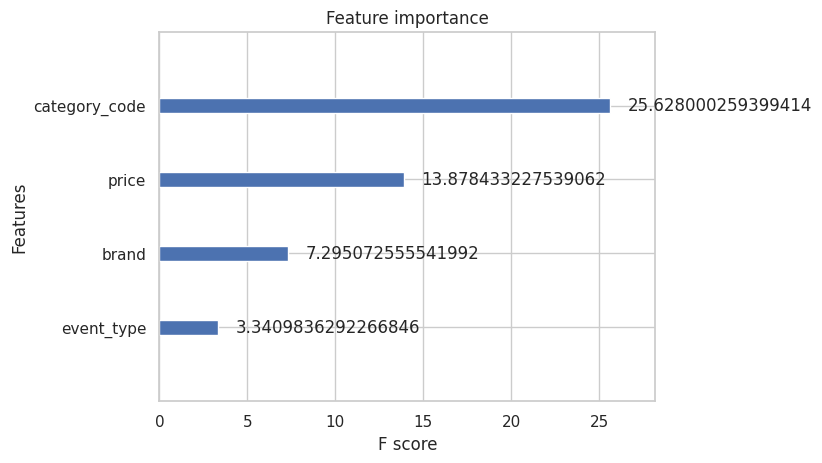

In [83]:
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()

> Churn Rate (24.61%)

> Offer loyalty programs, personalized discounts, and cart reminders.
High View, Low Cart, Lowest Purchase

> Improve product pages, use social proof, and simplify the checkout process.
View Events (Peak at 10 AM)

> Run flash sales or promotions during peak times.
Cart Events

> Incentivize cart additions with discounts or free shipping.
Purchase Events

> Send retargeting ads and highlight return policies to encourage purchases.
Brand Loyalty (Samsung Popularity)

> Partner with Samsung for exclusive deals or promote competing brands.
Short Sessions

> Use exit-intent popups and optimize user engagement with interactive content.
Bounce Rate

> Improve landing pages, speed, and CTAs; use A/B testing.
Top Users

> Reward high-engagement users and target high-view/low-purchase users with offers.
View-to-Cart Ratio

> Create urgency (e.g., "Only X left!") and simplify add-to-cart actions.
Cart-to-Purchase Ratio

> Address cart abandonment with clear shipping info and reminders.
View-to-Cart vs. Cart-to-Purchase

> Target high-ratio users as advocates; fix bottlenecks for low-ratio users.